Programación para la ciencia de datos - PEC4
============================

En este Notebook encontraréis un ejercicio que supone la cuarta actividad de evaluación continuada (PEC) de la asignatura. Esta PEC consta de un único ejercicio a resolver, que engloba muchos de los conceptos cubiertos durante la asignatura.

El objetivo de este ejercicio es desarrollar un **paquete de Python**, fuera del entorno de Notebooks, que nos permita resolver el problema dado. Este tendrá que incluir el correspondiente código organizado lógicamente (separado en módulos, organizados por funcionalidad), la documentación del código (docstrings) y tests. Además, se deben incluir los correspondientes archivos de documentación de alto nivel (README), así como los archivos de licencia y dependencias (`requirements.txt`). 

Se nos pide que implementemos un paquete de Python que sea capaz de realizar un análisis de datos
con información genética sobre el Bacilo de Koch. En particular, nos centraremos en las *pautas abiertas de lectura* de los genes del [Bacilo de Koch](https://en.wikipedia.org/wiki/mycobacterium_tuberculosis). Las *pautas abiertas de lectura* son más conocidas por su acrónimo *ORF* que viene de su nombre en inglés *open reading frame*. El [ORF](http://bioweb.uwlax.edu/genweb/molecular/seq_anal/translation/translation.html) es una secuencia de nucleótidos que potencialmente puede codificar una proteína. En los organismos eucariontes, como somos los seres humanos, cada gen tiene un único ORF. Pero este no es el caso de las bacterias, que son organismos procariontes.

# Los datos

Los datos a analizar nos son proporcionados en dos colecciones de datos separadas: `tb_functions.pl` y `orfs/tb_data_0x.pl`. Estos datos provienen del [repositorio UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/m.+Tuberculosis+Genes) y tienen formado de *datalog*.

`tb_functions.pl` contiene información general sobre los genes y sus clases funcionales. Mientras que `tb_data_0X.pl` contiene información detallada sobre todos los genes indicados.

Echando un vistazo a los archivos proporcionados, podréis ver que los diferentes archivos contienen bastante información. Para resolver el ejercicio propuesto, sólo será necesario usar una cantidad muy reducida de esta.


## tb_functions.pl
El archivo `tb_functions.pl` contiene información sobre 123 clases funcionales de ORFs y tiene la siguiente estructura:

```
class([1,0,0,0],"Small-molecule metabolism ").
class([1,1,0,0],"Degradation ").
class([1,1,1,0],"Carbon compounds ").
function(tb186,[1,1,1,0],'bglS',"beta-glucosidase").
function(tb2202,[1,1,1,0],'cbhK',"carbohydrate kinase").
function(tb727,[1,1,1,0],'fucA',"L-fuculose phosphate aldolase").
class([1,1,2,0],"Amino acids and amines ").
function(tb1905,[1,1,2,0],'aao',"D-amino acid oxidase").
function(tb2531,[1,1,2,0],'adi',"ornithine/arginine decarboxylase").
function(tb2780,[1,1,2,0],'ald',"L-alanine dehydrogenase").
function(tb1538,[1,1,2,0],'ansA',"L-asparaginase").
...
```

Donde hay dos tipos de entrada:

`class`: tiene 2 elementos separados por comas siempre presentados en el siguiente orden:
* *identificador de la clase*: lista de 4 números que describe la clase en 4 dimensiones diferentes (separados por comas y entre corchetes), y
* *descripción de la clase*: string que contiene la descripción de la clase, ninguna clase comparte descripción con otra clase (string entre comillas dobles).

`function`: tiene 4 elementos separados por comas siempre presentados en el siguiente orden:
* *ORF*: pauta abierta de lectura (en inglés *open reading frame*) (string sin comillas),
* *identificador de la clase*: lista de 4 números que describe la clase en 4 dimensiones diferentes (separados por comas y entre corchetes),
* *nombre del gen*: nombre del gen o valor *null* si el gen no tiene nombre (string entre comillas simples), y
* *descripción ORF*: descripción de la pauta de lectura (string entre comillas dobles).

## tb_data_0X.pl
Los archivos `tb_data_0X.pl` tienen la siguiente estructura:

```
begin(model(tb4)).
tb_protein(tb4).
function(5,0,0,0,'null','null').
coding_region(4434,4994).
tb_mol_wt(19934).
...
sequence_length(187).
amino_acid_pair_ratio(a,a,24.8).
amino_acid_pair_ratio(a,c,0.0).
amino_acid_pair_ratio(a,d,0.0).
amino_acid_pair_ratio(a,e,18.6).
amino_acid_pair_ratio(a,f,0.0).
amino_acid_pair_ratio(a,g,12.4).
...
tb_to_tb_evalue(tb3671,1.100000e-01).
tb_to_tb_evalue(tb405,4.300000e-01).
tb_to_tb_evalue(tb3225,5.600000e-01).
...
species(p35925,'streptomyces_coelicolor').
classification(p35925,bacteria).
classification(p35925,firmicutes).
classification(p35925,actinobacteria).
classification(p35925,actinobacteridae).
classification(p35925,actinomycetales).
classification(p35925,streptomycineae).
classification(p35925,streptomycetaceae).
classification(p35925,streptomyces).
mol_wt(p35925,19772).
keyword(p35925,'hypothetical_protein').
db_ref(p35925,embl,l27063,g436026,null).
signalip(c,35,no).
signalip(y,35,no).
signalip(s,54,no).
signalip(ss,1,34,no).
signalip(cleavage,null,null).
hydro_cons(-0.498,-0.474,0.624,3.248,0.278).
end(model(tb4)).
begin(model(tb5)).
...
end(model(tb3915)).
```

Donde los datos para un único ORF están capturados entre los delimitadores:
```
begin(model(ORF))
end(model(ORF))
```

Y el atributo `tb_tono_tb_evalue(ORF, E-value)` muestra la relación con otros ORFs.

# Ejercicio

Primero, será necesario que leáis los archivos facilitados de la forma más óptima teniendo en cuenta las tareas pedidas. Tendréis que justificar vuestra decisión.

In [2]:
# Importo los módulos necesarios
import pandas as pd
import glob
import matplotlib.pyplot as plt
import re

In [3]:
# Pandas me da el siguiente error:
# A value is trying to be set on
# a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
# disable chained assignments
pd.options.mode.chained_assignment = None

## Carga ficherox "txt"

En este apartado cargo el fichero txt de la carpeta data/orfs leyendo linea a lines, filtrando por lineas, generando sublista, realizando unas transformaciones y generando el dataframe **txt_data**

In [4]:
# obtengo una lista con todos los txt contenidos en un directorio
txt_files = glob.glob("data/orfs/*.txt")


def read_lists():
    """
    Parsear un texto dado por un archivo

    Parameters
    ----------


    Returns
    -------
    data : lista de distas
        Parsed data

    """
    for i in txt_files:
        with open(i) as file:
            sublist = []
            previous_line = ''
            # Genero un patron donde solo me busque la lineas que contengan
            # las palabras "begin, funciton, tb_protein, tb_to_tb_evalue, end"
            pattern = re.compile(
                r'\bbegin\b | \bfunction\b | \btb_protein\b | \btb_to_tb_evalue\b | \bend\b',
                flags=re.I | re.X)
            for line in file:
                # realizo transformaciones
                line = line.replace('.', '')
                line = line.replace('(', ";(")
                line = line.replace('begin;(model', "begin_model")
                line = line.replace('end;(model', "end_model")
                line = line.replace('))', ")")
                line = line.replace(')', "")
                line = line.replace('(', "")
                line = line.strip()
                # Le indico donde comienza y termina cada sublista
                if line.startswith(
                                    'begin_model'
                                    ) and previous_line.startswith(
                                    'end_model'
                                    ):
                    yield sublist
                    sublist = []
                # Le informo que debe buscar las palabras del patros para
                # añadir ilas a la sublista
                if pattern.search(line) != None:
                    # voy añadiendo los datos a la sublista
                    sublist.append(line.split(';'))
                # sublist.append(line)
                previous_line = line
            # obtengo la sublista
            return sublist


# creo una lista vacia para recolectar los datos
data = []

# Realizo una iteración para generar una lista de listas donde en
# cada lista contiene la sublista generadas anteriormente
for sublist in read_lists():
    data.append(sublist)

# convierto la lista en un dataframe
def appen_data(data):
    """
    Con esta función lo que hago es convertir las listas de la función
    anterior en un dataframe.
    :param data:
    :return:
    """
    def countList(data):
        """
        Función destinada a obtener el número de listas generadas
        :param data: la lista generada anteriormente
        :return: el número de listas
        """
        return len(data)


    # Genero una función para unir las columnas con
    # mismo nombre se unan y se separen por ';'
    def sjoin(x):
        """
        Función generada para fusionar las columnas con mismo nombre
        se unan incorporando el detalle de cada una de ellas
        y se separen por ";"
        :param x: columna a unir
        :return: los valores de las columnas unidas
        """
        return ';'.join(x[x.notnull()].astype(str))


    # Creo un dataframe vacio para agrupar los dataframes
    # que generamos con las listas
    df_a = pd.DataFrame()
    # genero una iteración donde convierto las listas en un dataframe
    for i in range(countList(data)):
        df_n = pd.DataFrame(data[i]).set_index(0)
        # pivoto el dataframe
        df_n = df_n.transpose()
        # uno las columnas con el mismo nombre
        df_n = df_n.groupby(level=0, axis=1).apply(
            lambda x: x.apply(sjoin, axis=1))
        df_a = df_a.append(df_n)
    return df_a

txt_data = appen_data(data)

# selecciono las columnas que me interesab
data_relac_txt = txt_data.iloc[:, [1, 2, 0]]

# las renombro
data_relac_txt.columns = ['ORF', 'relacion_ORF', 'function']

# Separo la columna función en otras
data_relac_txt[['clase',
                'name_gem',
                'descripcion']] = data_relac_txt['function'].str.split(
                ",'", expand=True)

# Genero nuevo dataframe seleccionando las columnas que me interesan
df_total = data_relac_txt[['clase',
                           'name_gem',
                           'descripcion',
                           'ORF',
                           'relacion_ORF']]
# Elimino valores na
df_total = df_total.dropna()
# genero nueva columna donde indico el número de relaciones
# sumando el número de "tb" que hay
df_total['numero de relaciones'] = df_total['relacion_ORF'].str.findall(
    r'tb').str.len()

In [5]:
df_total.head()

,clase,name_gem,descripcion,ORF,relacion_ORF,numero de relaciones
1,"6,0,0,0",null',null',tb8,"tb3383,2000000e-03;tb3802,4000000e-03;tb2165,9...",34
1,"5,0,0,0",null',null',tb25,"tb739,4000000e-12;tb26,2000000e-11;tb3896,2000...",29
1,"6,0,0,0",null',null',tb49,"tb2946,1500000e+00;tb2294,7400000e+00;tb589,74...",4
1,"2,2,4,0",celA',cellulase/endoglucanase',tb62,"tb2123,1000000e-02;tb2376,5100000e-02;tb768,67...",33
1,"1,2,7,0",hycQ',probable formate hydrogenlyase subunit',tb86,"tb83,2000000e-38;tb3158,1000000e-30;tb3156,200...",107


## Carga fichero "tb_functions.pl"

En este apartado cargo el fichero tb_functions.pl leyendo linea a lines, realizando unas transformaciones y generando el dataframe **df**

In [6]:
file = 'data/tb_functions.pl'


def parse_file(file):
    """
    Parse text at given filepath
    Parameters
    ----------
    Filepath for file_object to be parsed
    Returns
    -------
    data : pd.DataFrame
        Parsed data

    """
    # Cargo el archivo de texto dentro de "content"
    with open(file) as f:
        content = f.readlines()

        content = [x.strip() for x in content]

        # creo la lista vaciacreate an empty list to collect the data
        events_cl = []
        # create an empty list to collect the data
        events_fc = []

        # this is to filter the lines in the data
        for line in content:
            # extracto la clase
            if 'class([' in line:
                line = line.replace('.', '')
                line = line.replace('"', '')
                line = line.replace(')', '')
                line = line.replace('],', '];')
                events_cl.append(line.split('('))
            # extracto la función
            if 'function(' in line:
                line = line.replace('").', '"')
                line = line.replace(',[', ';[')
                line = line.replace("],'", '];"')
                line = line.replace("',", '";')
                events_fc.append(line.split('('))

        # para el caso de las clases
        # convierto la lista en dataframe
        data_class = pd.DataFrame(events_cl)
        # divido la columna en 2 columnas nuevas
        data_class[['clase',
                    'desc']] = data_class[1].str.split(';',
                                                       1,
                                                       expand=True)
        # Selecciono las columnas necesarias
        data_class = data_class[['clase', 'desc']]
        # Para el caso de las funciones
        # convierto la lista en dataframe
        data_fc = pd.DataFrame(events_fc)
        # divido la columna en 2 columnas nuevas
        data_fc[['ORF',
                 'clase',
                 'name_gem',
                 'desc_ORF']] = data_fc[1].str.split(';',
                                                     3,
                                                     expand=True)
        # Selecciono las columnas necesarias
        data_fc = data_fc[['ORF', 'clase', 'name_gem', 'desc_ORF']]
        # los 2 dataframes
        df_merged = pd.merge(data_class, data_fc, on='clase', how='outer')

    return df_merged


# Genero el dataframe con el fichero 'tb_fuctions.plt'
df = parse_file('data/tb_functions.pl')

1.1 Calcular cuántos ORFs pertenecen a cada clase. 

In [7]:
def grafico(x):
    """
    Función destinada a generar la gráfica para reproducir los
    ORFs que pertenecen a cada clase
    :param x: introducimos el valor
    :returns obtenemos la gráfica y un fichero
    """
    ax = x.plot(kind='barh', figsize=(8, 20), color='#86bf91',
                zorder=2, width=0.85)

    # Despine
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Switch off ticks
    ax.tick_params(axis="both", which="both",
                   bottom="off", top="off", labelbottom="on",
                   left="off", right="off", labelleft="on")

    # Draw vertical axis lines
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.3,
                   color='#eeeeee', zorder=1)

    [ax.text(v, i, '{}'.format(v)) for i, v in enumerate(x)]

    # Set x-axis labe
    ax.set_xlabel("Número de ORF", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    ax.set_ylabel("Clase", labelpad=20, weight='bold', size=12)
    plt.savefig(f"./graficos/numero_ORF.png")
    plt.show()
    plt.close()

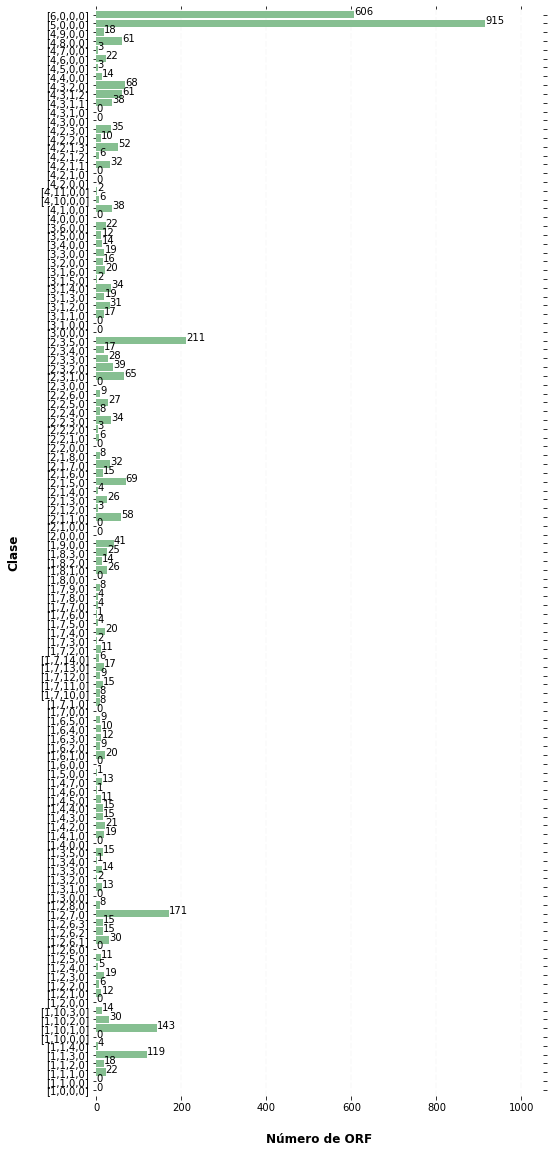

In [8]:
def primera_grafica(df):
    """Función destinada a realizar un recuento de las ORFs que
    tiene cada clase y su resultado mostrarlo en una gráfica utilizando
    la función grafico
    :param x: dataframe
    :returns obtenemos la gráfica
    """
    # Agrupo las clases y cuento el número de ORF
    group_clase_count = df.groupby(['clase'])['ORF'].count()
    # Aplico la función al resultado.
    grafico(group_clase_count)


primera_grafica(df)

1.2 Dado que el Bacilo de Koch afecta sobre todo a los pulmones, queremos que mostréis por pantalla cuántos ORFs pertenecen a la clase que tiene Respiration como descripción. Mostrad el resultado por pantalla debidamente formateado (utilizando el método format() u otro similar), incluyendo un mensaje explicativo de los valores que enseñáis.

In [9]:
def result_respir():
    """
    Función para mostrar en pantalla el nº de ORF que
    pertenecen a la clase que tiene Respiration como
    descripcion
    """
    result_respiration = df[df.desc.str.contains(
        'Respiration', case=False)].sum()
    print(
        "El Nº de ORF incluidos en la clase con descripción "
        "'Respiration' es: {} \n\n".
        format(result_respiration['ORF']))


result_respir()

El Nº de ORF incluidos en la clase con descripción 'Respiration' es: 0 




2.1 El número de clases que contienen como mínimo un ORF con el patrón indicado en su descripción. 

In [11]:
# Genero una función para mostrar en pantalla el
# esultado de este ejercicio
def plot_pie(x, names):
    """
    Genero una función donde obtengo en formato tarta el
    número de clases
    :param x
    :param names: el patrón correspondiente
    :return:
    """
    # eliminio el index
    x = x.reset_index()
    # convierto un dataframe solo con el campo seleccionado
    x = pd.DataFrame(x)['desc_ORF']
    x.index += 1
    x.plot.pie(figsize=(8, 8))
    plt.title(f"El Nº de clases con mínimo de 1 ORF con patron "
              f"${names}$", fontsize=14, weight="bold")
    plt.ylabel("Porcion clase sobre total")
    plt.xlabel("Total clases: {}".format(len(x)))
    # guardo la gráfoca en un lugar adecuado
    plt.savefig(f"./graficos/grafica_patron_{names}.png")
    # muestro en pantalla
    plt.show()
    plt.close()
    return plot_pie

El número de clases que contienen como mínimo un ORF con el patron 'que contiene el término protein'.  43 




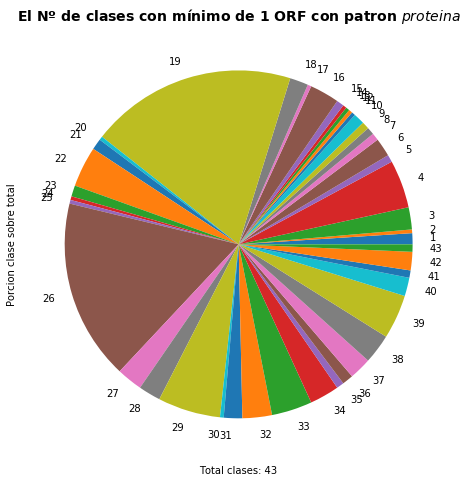

In [12]:
def num_clases_protein(df):
    """
    Función para mostrar en pantalla el nº de clases
    con un mínimo de un ORF con el patron 'termino'
    proteina
    descripcion
    :param x: dataframe
    :returns resultado consulta
    """
    # Realizo la busqueda
    des_ORF_protein = df[df['desc_ORF'].str.contains(r'protein', re.IGNORECASE,
                                                     regex=False, na=False)]
    # agrupo y cuento las clases
    protein = des_ORF_protein.groupby(['clase'])['desc_ORF'].count()
    # obtengo el número
    numero = len(protein)
    # imprimo el resultado
    print(
        "El número de clases que contienen como mínimo un ORF con el patron "
        "'que contiene el término protein'.  {} \n\n". format(numero))

    # aplico la función al resultado anterior
    plot_pie(protein, 'proteina')


num_clases_protein(df)

El número de clases según el segundo patron 'La descripcióncontiene una palabra de 13 caracteres y esta contiene el término *hydro*' es:21 




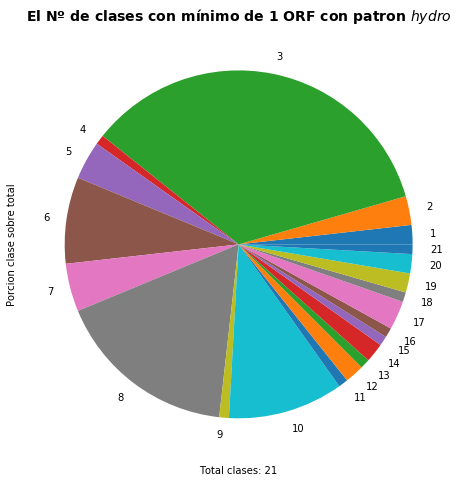

In [13]:
def num_clases_hydro(df):
    """
    Función para mostrar en pantalla el nº de clases
    con un mínimo de un ORF con el patron 'termino'
    hydro y contiene una palabra de 13 caracteres en 
    descripcion
    :param x: dataframe
    :returns resultado consulta
    """
    # Busco las palabras que contengan 13 caracteres
    ORF_hydro_13 = df[df['desc_ORF'].str.contains(r'\b\w{13}\b') == True]
    # dentro de ese resultado, que me ofrezca los que contienen
    # la palabra 'hydro'
    ORF_hydro_13 = ORF_hydro_13[ORF_hydro_13['desc_ORF'].str.contains(
                                                        r'hydro') == True]
    # agrupo y cuento
    hydro = ORF_hydro_13.groupby(['clase'])['desc_ORF'].count()
    # cuento el número de clases
    numero = len(hydro)
    # imprimo el resultado
    print("El número de clases según el segundo patron 'La descripción"
          "contiene una palabra de 13 caracteres y esta contiene el "
          "término *hydro*' es :{} \n\n".format(numero))
    # grafico
    plot_pie(hydro, 'hydro')


num_clases_hydro(df)

2.2 El número promedio de ORFs con los cuales se relacionan los ORFs con el patrón indicado en su descripción.

In [14]:
# Genero la función para las gráficas de los promedios
def graf_relac(x, names):
    """
    Función destinada a generar las gráficas de los promedios de relaciones
    según el patrón correspondiente
    :param x: el datafame de los ORF con el número de relaciones
    :param names: Indicamos el patron
    :return: la gráfica
    """
    x.plot.barh('ORF', 'numero de relaciones', figsize=(8, 10))
    # muestro en patalla la media
    plt.axvline(x['numero de relaciones'].mean(),
                color='r', linestyle='--', label='media')
    # la leyenda en la parte superior derecha
    plt.legend(loc='upper right')
    # titulo
    plt.title(f"Nº de ORF relacionados con otro ORF y su promedio ${names}$",
              fontsize=14,
              weight="bold")
    # etiquetas
    plt.xlabel("Nº de ORF")
    plt.ylabel("ORF")
    # guardo en fichero png la gŕafica
    plt.savefig(f"./graficos/grafica_relaciones_patron_{names}.png")
    # muestro en pantalla
    plt.show()
    # cierro
    plt.close()
    return plot_pie

El número promedio de ORFs con los cuales se relacionan losORFs con el patron 'que contiene el término protein'. 32.833333333333336 




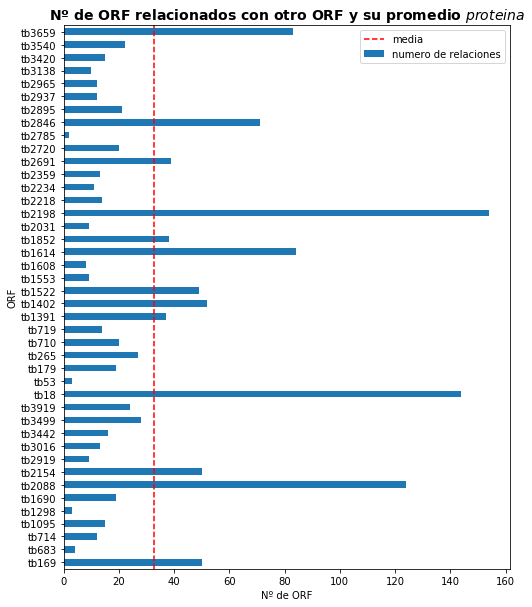

In [15]:
def promedio_patron_protein(df_total):
    """
    Función que generamos una grafica a partir del 
    filtro según patrón "protein" en el apartado descripción 
    del dataset
    :param: dataframe
    :return: Resultado impreso y la gráfica
    """
    # filtro los valores que contengan la palabra 'protein'
    df_total_protein = df_total[df_total['descripcion'].str.contains(
        r'protein', regex=False, na=False)]
    # selecciono 2 columnas
    prome_relac_protein = df_total_protein[['ORF', 'numero de relaciones']]
    # obtengo la media
    n_prome_relac_protein = float(
                    df_total_protein[['numero de relaciones']].mean())
    # muestro el resultado
    print("El número promedio de ORFs con los cuales se relacionan los"
          "ORFs con el patron 'que contiene el término protein'. {} \n\n".format(
            n_prome_relac_protein))
    # aplico la función a los datos obtenidos
    graf_relac(prome_relac_protein, ' proteina')


promedio_patron_protein(df_total)

El número promedio de ORFs con los cuales se relacionanlos ORFs según el segundo patron 'La descripcióncontiene una palabra de 13 caracteres y esta contiene el término *hydro*' es: 40.0 




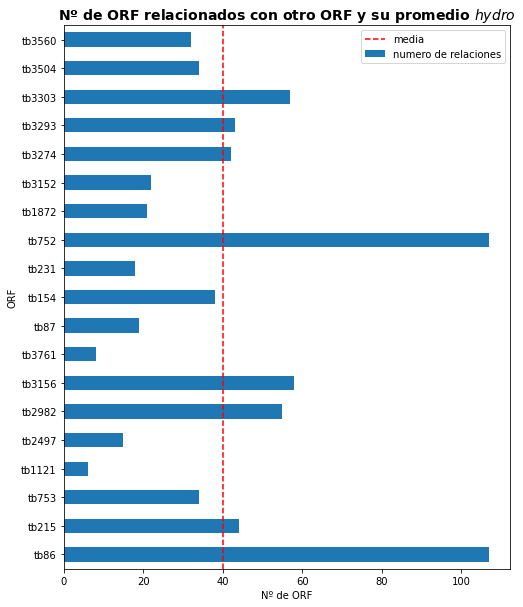

In [14]:
def promedio_patron_hydro(df_total):
    """
    Función que generamos una grafica a partir del 
    filtro según patrón "hydro" en el apartado descripción 
    del dataset
    :param: dataframe
    :return: resultado
    """
    df_total_hydro = df_total[df_total['descripcion'].str.contains(
                                                            r'\b\w{13}\b') == True]
    df_total_hydro = df_total_hydro[df_total_hydro['descripcion'].str.contains(
                                                            r'hydro') == True]
    n_prome_relac_hydro = float(df_total_hydro[['numero de relaciones']].mean())
    print("El número promedio de ORFs con los cuales se relacionan"
          "los ORFs según el segundo patron 'La descripción"
          "contiene una palabra de 13 caracteres y esta contiene el "
          "término *hydro*' es: {} \n\n".format(n_prome_relac_hydro))
    graf_relac(df_total_hydro, 'hydro')
    
    
promedio_patron_hydro(df_total)

Después, tendréis que generar funciones que os permitan hacer los siguientes cálculos:

1. Dada la colección de clases funcionales:
    <br>1.1 Calcular cuántos ORFs pertenecen a cada clase.
    <br>1.2 Dado que el Bacilo de Koch afecta sobre todo a los pulmones, queremos que mostréis por pantalla cuántos ORFs pertenecen a la clase que tiene *Respiration* como descripción. Mostrad el resultado por pantalla debidamente formateado (utilizando el método `format()` u otro similar), incluyendo un mensaje explicativo de los valores que enseñáis.<br>

2. Para cada patrón listado`*`, calcular:
    <br>2.1 El número de clases que contienen como mínimo un ORF con el patrón indicado en su descripción.
    <br>2.2 El número promedio de ORFs con los cuales se relacionan los ORFs con el patrón indicado en su descripción.<br><br>
    `*` Los patrones para los cuales tendréis que resolver los cálculos 2.1 y 2.2 son:
    - La descripción contiene el término *protein*. Por ejemplo, el ORF con descripción *electron transfer flavoprotein alpha subunit* encajaría con esta definición.
    - La descripción contiene una palabra de 13 caracteres y esta contiene el término *hydro*. Por ejemplo, el ORF con descripción *3-hydroxyacyl-CoA dehydrogenase* encajaría con esta definición.<br>  

3. Para cada entero M entre 2 y 9 (ambos incluidos), calcula el número de clases que tienen como mínimo una *dimensión* mayor estricta (>) que 0 y a la vez múltiple de M. Con el término dimensión nos referimos a cada uno de los 4 números que forman el identificador de la clase (explicado en la sección anterior). Este cálculo tendrá que resultar en algo como:
```
M=2: ? clases
M=3: ? clases
...
M=9: ? clases
``` 
donde ? representa un entero.

In [16]:
def clases_condicional(df):
    """
    Función destinada a obtener el número de clases que tienen 
    como mínimo una dimensión mayor estricta (>) que 0 y a la
    vez múltiple de M entre 2 y 9.
    :parameter: dataframe
    :return:
    número de clases que tienen como mínimo una dimensión
    mayor estricta (>) que 0 y a la vez múltiple de M entre 2 y 9.
    """
    # Selecciono la columna clase del dataframe y realizo unas modificaciones
    df['clase'] = df['clase'].str.replace(
        '[', '').str.replace(']', '').str.replace("''", "")
    # obtengo una lista de las cláses únicas
    clase_uniq = df['clase'].unique().tolist()
    # Genero una lista vacia
    lista = []
    print("Para cada entero M entre 2 y 9 (ambos incluidos),"
          "calcula el número de clases que tienen como mínimo"
          "una *dimensión* mayor estricta (>) que 0 y a la vez"
          "múltiple de M.")
    # Realizo una iteración para generar una lista de listas
    # selecciono cada uno de los valores de las lista
    for j in range(len(clase_uniq)):
        # divido el elemento correspondiente
        x = clase_uniq[j].split(',')
        # convierto el str en int
        x = [int(i) for i in x]
        # añado a la nueva lista
        lista.append(x)
    # genero una iteración para obtener el resultado solicitado
    for i in range(2, 10):
        # any() usado para filtrar elementos
        # selecciono las que tienen al menos un 0
        lista_zero = [sub for sub in lista if(any(ele > 0 for ele in sub))]
        # para evitar que a la hora de ejecutar el siguiente condicionante
        # me selecciono el valor 0 ya que '0%i==0' y me lo contaría
        # sustituyo su valor por -1
        lista_zeros = [[-1 if x == 0 else x for x in y] for y in lista_zero]
        # seleccion las listas que es multiple por M
        res = [subs for subs in lista_zeros if(any(
                                ele % i == 0 for ele in subs))]
        # imprimo el resultado según el formato solicitado
        print("M = {}:  ".format(i) + str(len(res)) + " clases")


# Ejecuto la función
clases_condicional(df)

Para cada entero M entre 2 y 9 (ambos incluidos),calcula el número de clases que tienen como mínimouna *dimensión* mayor estricta (>) que 0 y a la vezmúltiple de M.
M = 2:  97 clases
M = 3:  60 clases
M = 4:  48 clases
M = 5:  19 clases
M = 6:  19 clases
M = 7:  19 clases
M = 8:  8 clases
M = 9:  3 clases


<ipython-input-16-aa95ddd2303c>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['clase'] = df['clase'].str.replace('[', '').str.replace(']', '').str.replace("''", "")


Además, tendréis que generar código que permita representar todos los resultados gráficamente (excepto para el cálculo 1.1). Para cada función hará falta que penséis y justifiquéis qué tipo de gráfica es la más adecuada para representar el resultado. 

El código tendrá que estar correctamente comentado, incluyendo documentación de funciones, y correctamente testado usando la librería `unittest`. Los tests proporcionados tendrán que dar cobertura como mínimo al 50% de la funcionalidad propuesta.

## Cobertura de los tests
La medición de la cobertura de los tests se utiliza para evaluar la eficacia de los tests propuestos. En particular, sirve para determinar la calidad de los tests desarrollados y para determinar las partes críticas del código que no han sido testadas. Para medir este valor, proponemos el uso de la herramienta [`Coverage.py`](https://coverage.readthedocs.io/en/coverage-5.3/). En la documentación podréis encontrar [cómo instalarla](https://coverage.readthedocs.io/en/coverage-5.3/install.html#install) y [cómo usarla](https://coverage.readthedocs.io/en/coverage-5.3/#quick-start).

Para evaluar la calidad de los tests desarrollados en la PAC4, pedimos un mínimo del 50% de cobertura.

# Uso de Git

Para poner en práctica lo que habéis aprendido en la Unidad 6 sobre `Git`, proponemos el uso de `GitHub Classroom` para desarrollar vuestro paquete de Python. GitHub Classroom es una herramienta gratuita de código abierto que ayuda a simplificar el uso educativo de GitHub. Hemos usado GitHub Classroom para crear una aula como esta y dónde hemos creado una tarea para la PAC4. Para hacer uso de este espacio que hemos creado, os aconsejamos seguir los pasos indicados en esta [guía](https://drive.google.com/file/d/12Ct8leC2wkmIK6c2JMgTGEWtZa7kg9PW/view?usp=sharing) donde se explica cómo crear un repositorio para trabajar en la tarea que hemos preparado. El enlace a la tarea lo encontraréis en el mensaje de la PAC4 publicado en el tablón del aula.

El uso de esta herramienta no es obligatorio para la evaluación de la PAC4, pero creemos que es una muy buena oportunidad para poner en práctica vuestros conocimientos en un entorno vital para todo el mundo que trabaje o quiera trabajar en el ámbito de la ciencia de datos.

# Criterios de corrección

Esta PEC se valorará siguiendo los criterios siguientes:

* **Funcionalidad** (5 puntos): Se valorará que el código implemente correctamente lo que pide el enunciado.
    * Lectura ficheros (1 punto)
    * Ejercicio 1 (0.5 puntos)
    * Ejercicio 2 (1.5 puntos)
    * Ejercicio 3 (1 punto)
    * Visualizaciones (1 punto)
* **Documentación** (0.5 puntos): Todas las funciones de los ejercicios de esta PEC tendrán que estar correctamente documentadas utilizando docstrings (en el formato que prefiráis). 
* **Modularidad** (1 punto): Se valorará la modularidad del código (tanto la organización del código en ficheros como la creación de funciones). 
* **Estilo** (0.5 puntos): El código tiene que seguir la guía de estilo de Python (PEP8), exceptuando los casos donde hacerlo complique la legibilidad del código.
* **Tests** (2 puntos): El código tiene que contener una o varias *suites* de tests que permitan comprobar el buen funcionamiento de las funciones implementadas, obteniendo un mínimo del 50% de cobertura.
* **Requerimientos** (0.5 puntos): Es necesario crear un fichero de requerimientos que liste (sólo) las librerías necesarias para ejecutar el código.
* **README** y **licencia** (0.5 puntos): Se valorará la creación de un fichero README, que presente el proyecto y explique cómo ejecutarlo, así como la inclusión de la licencia bajo la cual se distribuye el código (podéis elegir la que queráis).


## Importante

**Nota 1**: Del mismo modo que en las PECs anteriores, los criterios transversales se valorarán de manera proporcional a la parte de la funcionalidad implementada. 

Por ejemplo, si el código únicamente implementa la mitad de la funcionalidad pedida, y la documentación de esta parte es perfecta, entonces la puntuación correspondiente a la parte de documentación será de 0.25.

**Nota 2**: Es imprescindible que el paquete que entreguéis se ejecute correctamente en la máquina virtual, y que el fichero de README que incluyáis explique claramente cómo se tiene que ejecutar vuestro código para generar las gráficas resultantes del análisis.

**Nota 3**: Entregad el paquete como un único archivo .zip en el Registro de Evaluación Continua. **El código de Python tendrá que estar escrito en ficheros planos de Python.**